1. Data collection
You can use the CoinGecko API to fetch historical price and volume data. You'll need to install the requests and pandas libraries (pip install requests pandas).
python

In [20]:
import requests
import pandas as pd
import time

def fetch_crypto_ohlc(coin_id, vs_currency, days):
    """
    Fetches historical OHLC (Open, High, Low, Close) data and volume from CoinGecko API.
    Args:
        coin_id (str): The ID of the cryptocurrency (e.g., 'bitcoin', 'ethereum').
        vs_currency (str): The currency to compare against (e.g., 'usd').
        days (int): The number of days of historical data to fetch.
    Returns:
        pd.DataFrame: A DataFrame containing OHLCV data.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/ohlc?vs_currency={vs_currency}&days={days}"
    response = requests.get(url)
    data = response.json()

    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['volume'] = 0

    market_data_url = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency={vs_currency}&ids={coin_id}"
    market_response = requests.get(market_data_url)
    market_data = market_response.json()
    if market_data:
        df['volume'] = market_data[0].get('total_volume', 0)

    return df

# Increase the number of days to fetch more data
bitcoin_data = fetch_crypto_ohlc('bitcoin', 'usd', 365)
print("Bitcoin OHLCV Data Head:")
print(bitcoin_data.head())

Bitcoin OHLCV Data Head:
   timestamp     open     high      low    close       volume
0 2024-09-14  58147.0  60655.0  57669.0  60621.0  47907266542
1 2024-09-18  60545.0  61243.0  57559.0  60317.0  47907266542
2 2024-09-22  60320.0  64082.0  59212.0  63403.0  47907266542
3 2024-09-26  63406.0  64755.0  62479.0  63152.0  47907266542
4 2024-09-30  63146.0  66439.0  62812.0  65664.0  47907266542


2. Data preprocessing
This involves handling missing values, cleaning, and normalizing data.

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = bitcoin_data.ffill()

scaler = MinMaxScaler()
features_to_scale = ['open', 'high', 'low', 'close', 'volume']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\nProcessed Data Head (Normalized):")
print(df.head())


Processed Data Head (Normalized):
   timestamp      open      high       low     close  volume
0 2025-06-17  0.130017  0.147564  0.333171  0.219669     0.0
1 2025-06-21  0.212996  0.084171  0.224836  0.000000     0.0
2 2025-06-25  0.000000  0.000000  0.000000  0.161166     0.0
3 2025-06-29  0.164637  0.110395  0.406620  0.242530     0.0
4 2025-07-03  0.242455  0.193289  0.375088  0.332053     0.0


3. Exploratory data analysis (EDA)
Visualize trends and patterns. You'll need matplotlib (pip install matplotlib).

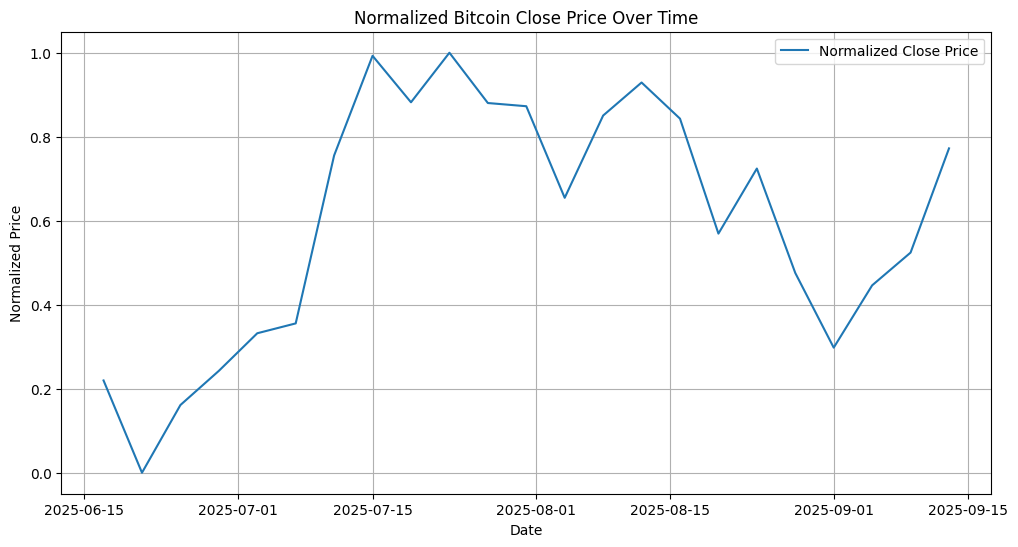


Correlation Matrix:
            open      high       low     close  volume
open    1.000000  0.927309  0.936293  0.826046     NaN
high    0.927309  1.000000  0.950391  0.930800     NaN
low     0.936293  0.950391  1.000000  0.912757     NaN
close   0.826046  0.930800  0.912757  1.000000     NaN
volume       NaN       NaN       NaN       NaN     NaN


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['close'], label='Normalized Close Price')
plt.title('Normalized Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()

print("\nCorrelation Matrix:")
print(df[features_to_scale].corr())


4. Feature engineering
Create new features from existing data, like moving averages or volatility measures.


In [11]:
df['SMA_5'] = df['close'].rolling(window=5).mean()
df['SMA_10'] = df['close'].rolling(window=10).mean()

df['Volatility'] = df['close'].rolling(window=5).std()

df = df.ffill().bfill()

print("\nData with Engineered Features Head:")
print(df.head())


Data with Engineered Features Head:
Empty DataFrame
Columns: [timestamp, open, high, low, close, volume, SMA_10, SMA_30, Volatility, SMA_5]
Index: []


5. Model selection
Choose appropriate models based on your data and objectives. LSTM networks are suitable for time series forecasting, while XGBoost can be used for regression.

6. Model training
Train the selected model using your processed dataset.

In [21]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = df[['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'Volatility']]
y = df['close'].shift(-1).dropna()

X = X.loc[y.index]


if X.shape[0] > 0 and y.shape[0] > 0:
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    print("\nXGBoost Model Trained on the entire dataset.")
else:
    print("\nNot enough data to train the model after preparing features and target variable.")
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


Not enough data to train the model after preparing features and target variable.
Shape of X: (0, 8), Shape of y: (0,)


7. Model evaluation
Assess the model's performance using relevant metrics.

In [22]:
if 'model' in locals() and 'X' in locals() and 'y' in locals() and not X.empty and not y.empty:

    print("WARNING: Evaluating the model on the training data due to insufficient data for a test split.")
    y_pred = model.predict(X)

    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"RMSE (on Training Data): {rmse:.4f}")
    print(f"MAE (on Training Data): {mae:.4f}")
    print(f"R-squared (on Training Data): {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y.index, y, label='Actual Close Price')
    plt.plot(y.index, y_pred, label='Predicted Close Price', alpha=0.7)
    plt.title('XGBoost Predictions vs Actual Values (on Training Data)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Model was not trained or data is insufficient for evaluation.")

Model was not trained or data is insufficient for evaluation.


I> Code documentation

In [23]:
def fetch_crypto_ohlc(coin_id, vs_currency, days):
    """
    Fetches historical OHLC (Open, High, Low, Close) and volume data from CoinGecko.

    Args:
        coin_id (str): The ID of the cryptocurrency (e.g., 'bitcoin').
        vs_currency (str): The currency to compare against (e.g., 'usd').
        days (int): The number of days of historical data to fetch.

    Returns:
        pd.DataFrame: A DataFrame containing OHLCV data.
    """

    pass


II> Report structure
A well-structured report guides the reader through your process, from the problem statement to the conclusion

III> Diagrams and visuals
Visuals are critical for explaining complex concepts and presenting results clearly.

IV> Deployment
Deploying your model makes it accessible for testing and predictions. Here are two common approaches.